In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm
from DataHandling import *
from ModelClasses import *
import matplotlib.pyplot as plt
from IDPredictor import *

In [2]:
# Define number of hours as length of demand
N_Hours = hours_per_year

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = 4

# Define epsilon
epsilon = 5/6


BatteryCapacity = 100
BatterPower = 100

BatteryEfficiency = 0.9274


In [3]:
def extract_capacity_results(res, case_id,capacity_results, kpi_dict):
    # Tag for column name
    
        # Process generation
        capnew_df = res.CapNew[['Plant', 'CapNew[GW]']].copy()
        capnew_df.columns = ['Plant', 'Capacity']
        capnew_df['Case'] = case_id
        capacity_results.append(capnew_df)

        # Process storage
        capstor_df = res.CapStor[['Plant', 'CapStor[GWh]']].copy()
        capstor_df.columns = ['Plant', 'Capacity']
        capstor_df['Case'] = case_id
        capacity_results.append(capstor_df)


        # Extract values
        avg_res = res.RESShare['RES Share'].mean()
        avg_co2 = res.CO2Intensity['CO2 Intensity [tCO2/MWh]'].mean()
        obj_val = res.obj

        # Fill into dict
        kpi_dict['Average RES Share'][case_id] = avg_res
        kpi_dict['Average CO2 Intensity'][case_id] = avg_co2
        kpi_dict['Objective Value'][case_id] = obj_val

        return capacity_results, kpi_dict

In [4]:
SetofCases = ['ReferenceCase','HighFuel', 'NetZero','HighFuel_NetZero','Situation2024','PoliticalTurnaround']#,'HighFuel', 'NetZero','HighFuel_NetZero']#,#'SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel'] #SetofCases = ['SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel']
SetofDeltas = [0,0.8]

# Initialization
capacity_results = []
kpi_dict = {
    'Average RES Share': {},
    'Average CO2 Intensity': {},
    'Objective Value': {}
}

DA_ID_price_frames = {}      # {case_id: DataFrame}
capture_price_dict = {}      # {case_id: Series}
stddev_dict = {
    'StdDev_DA_Prices': {},
    'StdDev_ID_Prices': {}
}
average_total_gen_dict = {}

for RunScenario in SetofCases:
    for delta in SetofDeltas:
        print(f'Running scenario: {RunScenario} with delta: {delta}')
        case_id = f'{RunScenario}_{delta}'

        # Load scenario data
        Demand, OpCost, CapOut, CO2Intensity, FixedOpex, StorExi, CapExi, CapLim = get_scenario_data(RunScenario)
        BigM = delta * sum(Demand)

        ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM, BatteryCapacity, BatterPower)
        DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaDis,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios, StorLim,CO2Intensity,StorCost_DF,FixedOpex,StorOpex,BatteryEfficiency)

        # Run capacity model
        capacity_problem = CapacityProblem(ParametersObj, DataObj)
        res = capacity_problem.res

        # Extract capacity arrays
        ResultsCapacity = np.array(res.CapNew['CapNew[GW]'])
        ResultsStorage = np.array(res.CapStor['CapStor[GWh]'])

        # Collect capacity results & KPIs
        extract_capacity_results(res, case_id, capacity_results, kpi_dict)

        # Run day-ahead model
        DA_problem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage, IDForecaster)
        res_DA = DA_problem.res
        DayAheadPrices = res_DA.DA_Prices
        IntraDayPrices = res_DA.IntraDay_PricesArray
        DayAheadPricesTransformed = DayAheadPrices.to_numpy()

        # ---------------------
        # 1. Save DA/ID prices
        

        columns = []
        price_columns = []

        for s in range(ParametersObj.N_Scen):
            DA_col = f"Scenario_{s}_DA"
            ID_col = f"Scenario_{s}_ID"
            columns.extend([DA_col, ID_col])

            DA_prices = res_DA.DA_Prices.iloc[:, s].values
            ID_prices = res_DA.IntraDay_PricesArray[:, s]

            price_columns.append(DA_prices)
            price_columns.append(ID_prices)

        # Stack all DA/ID columns horizontally
        data = np.column_stack(price_columns)

        # Build DataFrame with Hour index
        df_prices = pd.DataFrame(data, columns=columns)
        df_prices['Hour'] = range(ParametersObj.N_Hours)
        DA_ID_price_frames[case_id] = df_prices.set_index('Hour')

        # ---------------------
        # 2. Save capture prices
        tech_means = res_DA.CapturePrices.astype(float).mean(axis=1)
        capture_price_dict[case_id] = tech_means

        # ---------------------
        # 3. Save std deviations
        std_da = res_DA.DA_Prices.std(axis=1).mean()
        std_id = pd.DataFrame(res_DA.IntraDay_PricesArray).std(axis=1).mean()
        stddev_dict['StdDev_DA_Prices'][case_id] = std_da
        stddev_dict['StdDev_ID_Prices'][case_id] = std_id

        # Save generation results
        average_total_gen_dict[f"{RunScenario}_{delta}"] = res_DA.AverageTotalGeneration



        BatteryOpt = BatteryOptimization(ParametersObj, DataObj, DayAheadPricesTransformed, IntraDayPrices)
        res_Batt = BatteryOpt.res

        # 5. Get the financial summary and add column average as a new row
        financial_df = res_Batt.FinancialSummary.copy()
        average_row = financial_df.mean(numeric_only=True)
        average_row.name = 'Average'
        financial_df = pd.concat([financial_df, pd.DataFrame([average_row])])

        # 6. Store as named DataFrame
        safe_case_id = case_id.replace(".", "_")
        globals()[f"{safe_case_id}_BatterySummary"] = financial_df  

# ---------------------
# FINAL DATAFRAMES

# Pivot: capacity results
cap_df = pd.concat(capacity_results, ignore_index=True)
FinalCapacityResults = cap_df.pivot(index='Plant', columns='Case', values='Capacity').fillna(0)

# KPIs
kpi_df = pd.DataFrame.from_dict(kpi_dict, orient='index')
kpi_df = kpi_df[sorted(kpi_df.columns)]

# Capture Prices
capture_price_df = pd.DataFrame(capture_price_dict)
capture_price_df = capture_price_df[sorted(capture_price_df.columns)]

# Std Devs
stddev_kpi_df = pd.DataFrame.from_dict(stddev_dict, orient='index')
stddev_kpi_df = stddev_kpi_df[sorted(stddev_kpi_df.columns)]

# Automatically assign each case DataFrame to a variable
for case_id, df in DA_ID_price_frames.items():
    safe_case_id = case_id.replace(".", "_")
    globals()[safe_case_id] = df

     



Running scenario: ReferenceCase with delta: 0
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-14
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 876003 rows, 630738 columns and 2835835 nonzeros
Model fingerprint: 0x631e106b
Variable types: 630734 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+00]
  Objective range  [2e+03, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 5e+03]
Presolve removed 282722 rows and 72463 columns
Presolve time: 3.40s
Presolved: 593281 rows, 558275 columns, 1779863 nonzeros
Variable types: 558275 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barr

### Create Plot for existing capacity

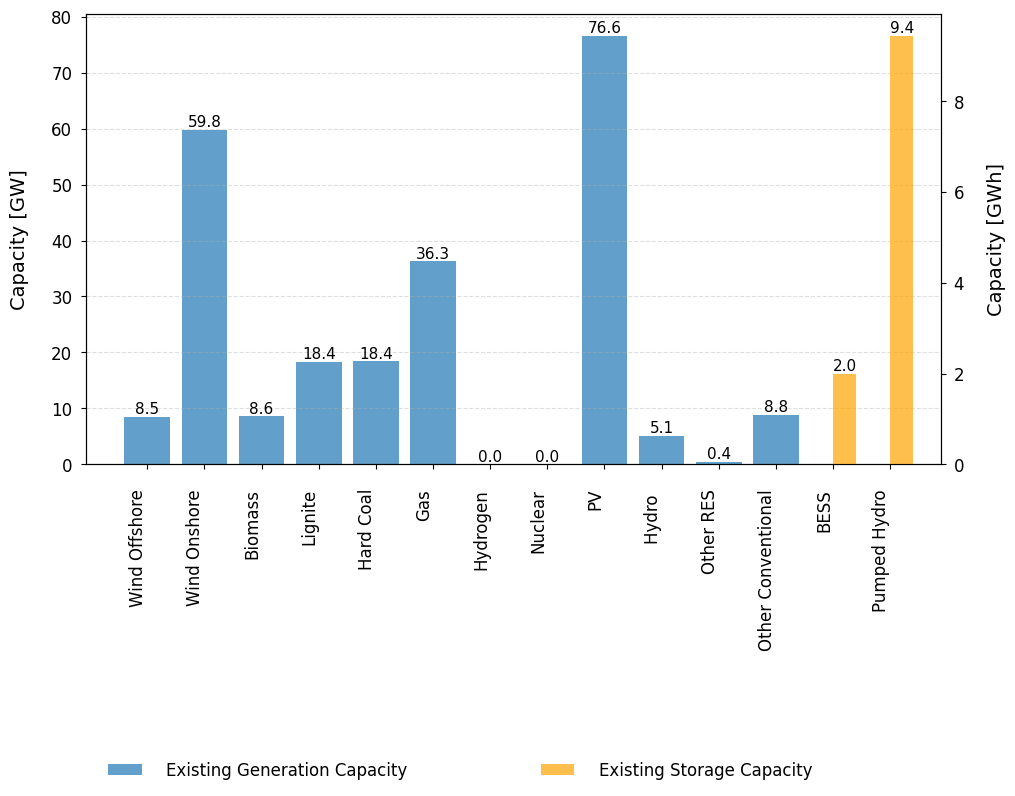

Saved: Pictures/existing_capacity_storage.svg


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- SVG: keep text as text for LaTeX ---
rcParams['svg.fonttype'] = 'none'

# Ensure output folder
os.makedirs("Pictures", exist_ok=True)

# Load data
StorExidf = pd.read_excel('Data/ReferenceCase/ExistingStorage.xlsx')
CapExidf = pd.read_excel('Data/ReferenceCase/ExistingCapacity.xlsx')

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis: Existing Generation Capacity
bars1 = ax1.bar(
    CapExidf['Technology'],
    CapExidf['Capacity [GW]'],
    label='Existing Generation Capacity',
    alpha=0.7
)
ax1.set_ylabel('Capacity [GW]', fontsize=14, labelpad=16)
ax1.tick_params(axis='y', labelsize=12, pad=6)

# Labels for generation bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}',
        ha='center', va='bottom', fontsize=11
    )

# Secondary axis: Existing Storage Capacity
ax2 = ax1.twinx()
bars2 = ax2.bar(
    StorExidf['Technology'],
    StorExidf['Capacity [GWh]'],
    label='Existing Storage Capacity',
    alpha=0.7, color='orange', width=0.4
)
ax2.set_ylabel('Capacity [GWh]', fontsize=14, labelpad=16)
ax2.tick_params(axis='y', labelsize=12, pad=6)

# Shift bars & add labels for storage
for bar in bars2:
    bar.set_x(bar.get_x() + 0.2)
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}',
        ha='center', va='bottom', fontsize=11
    )

# --- Align x-axis labels further down ---
for lbl in ax1.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_horizontalalignment('right')
    lbl.set_verticalalignment('bottom')
    lbl.set_rotation_mode('anchor')
ax1.tick_params(axis='x', labelsize=12, pad=14)

# Grid for primary axis
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)

# Layout & legend with more spacing between elements
plt.subplots_adjust(top=0.95, bottom=0.20, right=0.98)
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    ncol=2,
    fontsize=12,
    columnspacing=8.0,   # more space between columns
    handletextpad=1.5,   # space between marker and text
    frameon=False        # remove legend border
)

# Save SVG
outfile = "Pictures/existing_capacity_storage.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Create Plot for new built capacity

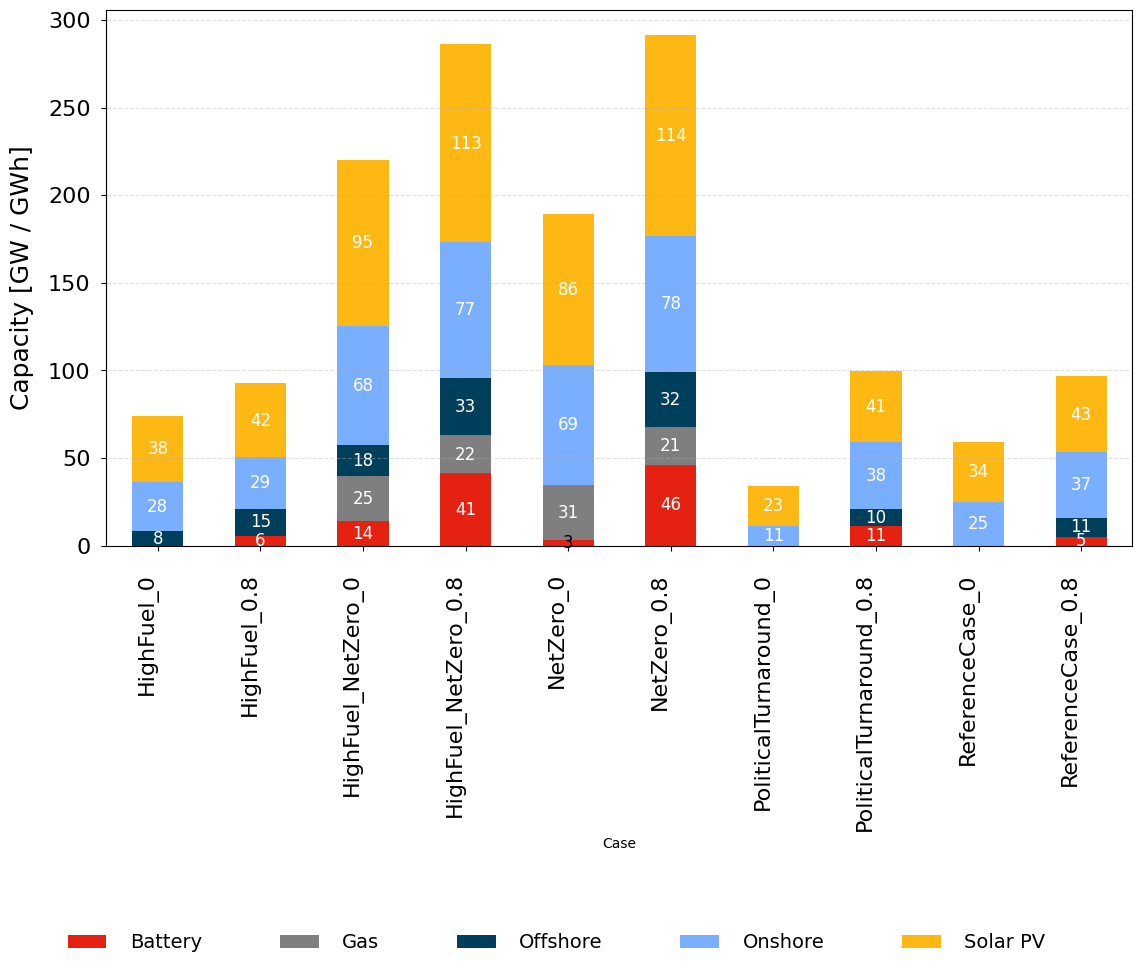

Saved: Pictures/scenario_stack.svg


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch

# --- SVG: keep text editable so LaTeX controls fonts ---
rcParams['svg.fonttype'] = 'none'
numeric_rows_sum = FinalCapacityResults.select_dtypes(include='number').sum(axis=1)
nonzero_plants = FinalCapacityResults.loc[numeric_rows_sum != 0]
data = nonzero_plants.T.iloc[:-2]

# --- assume data is already prepared and Political Turnaround - 0.8 removed ---
data_num = data.apply(pd.to_numeric, errors='coerce').fillna(0)
if 'Political Turnaround - 0.8' in data_num.index:
    data_num = data_num.drop(index='Political Turnaround - 0.8')



plant_colors = {
    'Solar PV': '#FDB813',   # Orange-yellow
    'Offshore': '#003f5c',   # Dark blue
    'Onshore':  '#7aafff',   # Light blue
    'Hydro':    '#2CA02C',   # Green
    'Gas':      '#7F7F7F',   # Gray
    'Nuclear':  '#9467BD',   # Purple
    'Battery':  '#E52211'    # Red
}
colors = [plant_colors.get(c, '#9e9e9e') for c in data_num.columns]

# --- plot ---
fig, ax = plt.subplots(figsize=(12, 8))
data_num.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Remove auto-legend from the plot
ax.legend_.remove()

# Axis labels & ticks
ax.set_ylabel('Capacity [GW / GWh]', fontsize=18, labelpad=10)
ax.tick_params(axis='y', labelsize=16, pad=8)

for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_horizontalalignment('right')
    lbl.set_verticalalignment('bottom')
    lbl.set_rotation_mode('anchor')
ax.tick_params(axis='x', labelsize=16, pad=16)

# Grid
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# Add values in stacked bars
for i, scenario in enumerate(data_num.index):
    cumulative = 0.0
    for plant in data_num.columns:
        val = data_num.at[scenario, plant]
        if val > 0:
            ax.text(i, cumulative + val / 2.0, f'{val:.0f}',
                    ha='center', va='center', fontsize=12,
                    color='white' if val > 5 else 'black')
            cumulative += val

# Legend below the plot only
legend_handles = [Patch(facecolor=plant_colors.get(c, '#9e9e9e'), label=c) for c in data_num.columns]
fig.legend(
    handles=legend_handles,
    labels=[h.get_label() for h in legend_handles],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=min(5, len(legend_handles)),
    fontsize=14,
    frameon=False,
    columnspacing=4.0,
    handletextpad=1.2,
    labelspacing=1.4
)

plt.subplots_adjust(top=0.95, bottom=0.28, right=0.98)

# Save SVG
os.makedirs("Pictures", exist_ok=True)
outfile = "Pictures/scenario_stack.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()
print(f"Saved: {outfile}")


### Plotting weather scenarios for one year

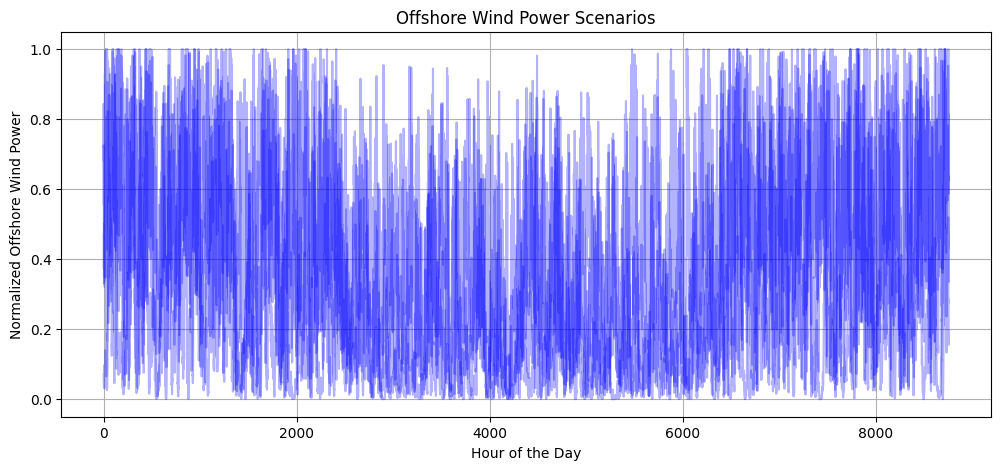

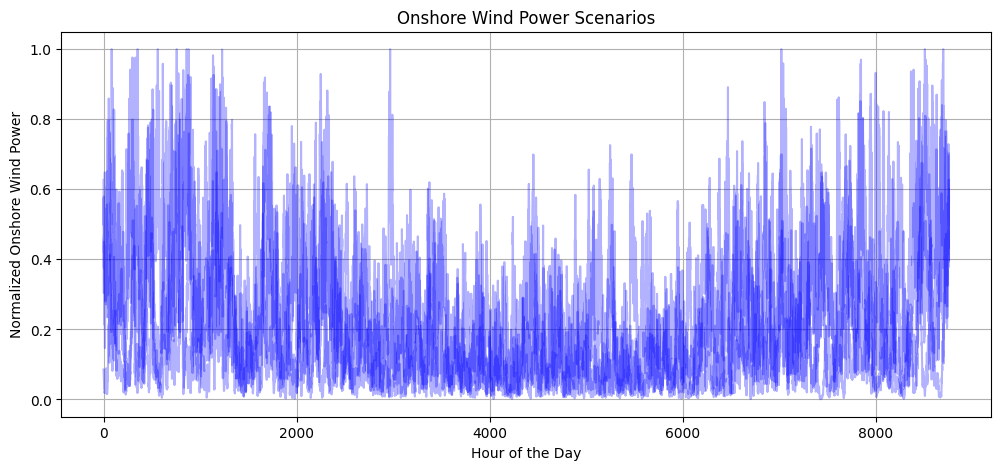

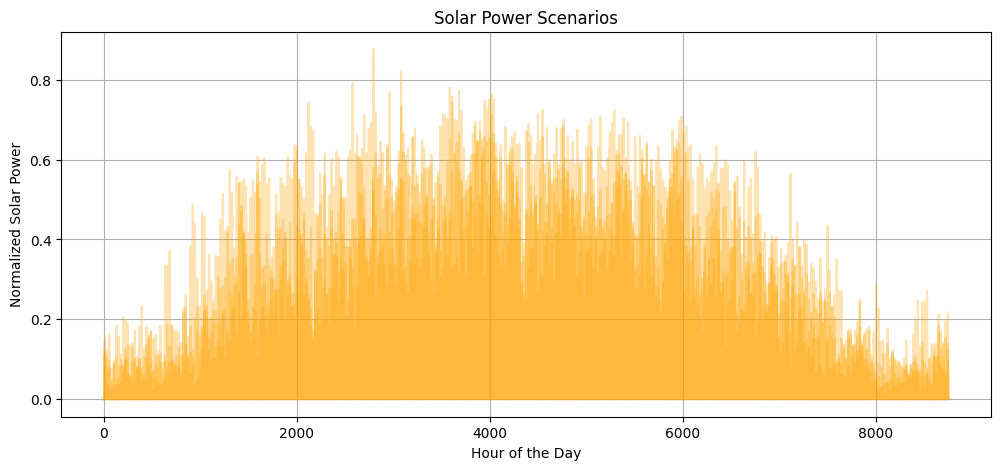

In [7]:


# Plot offshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.show()

# Plot onshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  
    plt.plot(range(N_Hours), Onwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

### Plotting Demand on summer and winter day

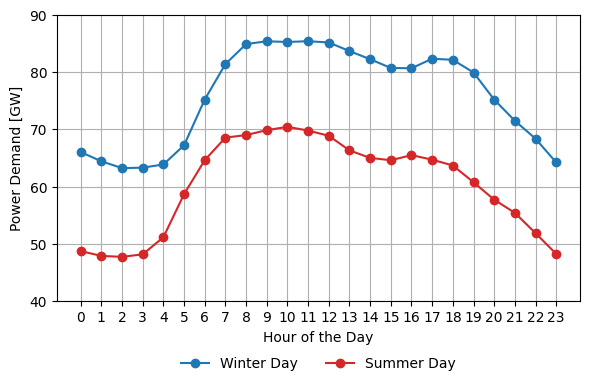

Saved: Pictures/demand_day17_and_day179.svg


In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Keep text editable so LaTeX can match fonts via \includesvg
rcParams['svg.fonttype'] = 'none'

# Output folder
os.makedirs("Pictures", exist_ok=True)

# Choose the two days (0-based: 0=Jan 1)
days = [16, 178]   # Day 17 and Day 179
labels = ["Winter Day", "Summer Day"]
colors = ["#1f77b4", "#d62728"]  # distinct colors

# X axis (hours)
hours = range(24)

plt.figure(figsize=(6, 4))
for d, lab, col in zip(days, labels, colors):
    start = d * 24
    end = start + 24
    series = Demand[start:end]
    plt.plot(hours, series, marker='o', label=lab, color=col, linewidth=1.5)

plt.xlabel("Hour of the Day")
plt.ylabel("Power Demand [GW]")
plt.xticks(hours)
plt.ylim(40, 90)
plt.grid(True)

# Legend below the plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)

# Save a single SVG for Overleaf
outfile = "Pictures/demand_day17_and_day179.svg"
plt.tight_layout()
plt.savefig(outfile, format="svg", bbox_inches="tight")

plt.show()
plt.close()
print(f"Saved: {outfile}")


### Plotting capacity factors on a summer day

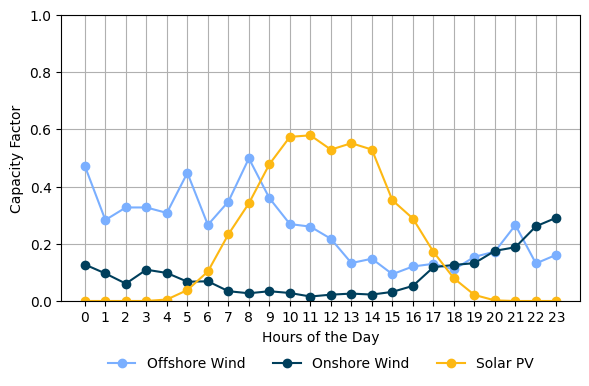

Saved: Pictures/scenarios_day181_s2.svg


In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Make SVG text editable so LaTeX matches your document fonts
rcParams['svg.fonttype'] = 'none'

# Output folder (matches your Overleaf setup)
os.makedirs("Pictures", exist_ok=True)

# Pick the day and the scenario to plot
day_index = 180        # e.g., day 181 (0-based)
scenario_index = 1     # choose which scenario to show

# Time slice for that day
start = day_index * 24
end = start + 24
hours = range(24)

# Extract one scenario for each tech
offshore = Offwind_scenarios[start:end, scenario_index]
onshore  = Onwind_scenarios[start:end, scenario_index]
solar    = Solar_scenarios[start:end, scenario_index]

# One combined plot
plt.figure(figsize=(6, 4))  # nice, scalable size for LaTeX
plt.plot(hours, offshore, label="Offshore Wind", marker='o', color = "#7aafff")
plt.plot(hours, onshore,  label="Onshore Wind",  marker='o', color ="#003f5c")
plt.plot(hours, solar, label="Solar PV", marker='o', color="#FDB813")


plt.xlabel("Hours of the Day")        # LaTeX will handle font size
plt.ylabel("Capacity Factor")
plt.xticks(hours)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # center below plot
    ncol=3,                       # one column per series
    frameon=False                 # optional: remove legend box
)

plt.tight_layout()

# Save SVG for Overleaf and also show locally
outfile = f"Pictures/scenarios_day{day_index+1}_s{scenario_index+1}.svg"
plt.savefig(outfile, format="svg")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting capacity factors on a winter day

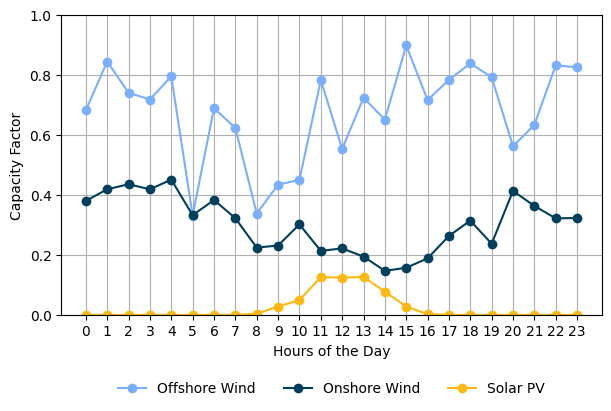

Saved: Pictures/scenarios_day1_s2.svg


In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Keep SVG text as text so LaTeX can match document fonts
rcParams['svg.fonttype'] = 'none'

# Output folder
os.makedirs("Pictures", exist_ok=True)

# Pick the day and the scenario to plot
day_index = 0
scenario_index = 1

# Time slice for that day
start = day_index * 24
end = start + 24
hours = range(24)

# Extract one scenario for each tech
offshore = Offwind_scenarios[start:end, scenario_index]
onshore  = Onwind_scenarios[start:end, scenario_index]
solar    = Solar_scenarios[start:end, scenario_index]

# Plot
plt.figure(figsize=(6, 4), constrained_layout=True)  # let MPL auto-handle spacing
plt.plot(hours, offshore, label="Offshore Wind", marker='o', color="#7aafff")
plt.plot(hours, onshore,  label="Onshore Wind",  marker='o', color="#003f5c")
plt.plot(hours, solar,    label="Solar PV",      marker='o', color="#FDB813")

plt.xlabel("Hours of the Day")
plt.ylabel("Capacity Factor")
plt.xticks(hours)
plt.ylim(0, 1)
plt.grid(True)

# Legend below plot
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=False
)

# Save SVG (tight bbox so LaTeX sees all the text space)
outfile = f"Pictures/scenarios_day{day_index+1}_s{scenario_index+1}.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Calculating average capacity factors

In [11]:
# Calculate the average capacity factor acrss all scenarios and hours
# for each renewable energy source
avg_offwind = np.mean(Offwind_scenarios)
avg_onwind = np.mean(Onwind_scenarios)
avg_solar = np.mean(Solar_scenarios)
print(f"Average Offshore Wind Capacity Factor: {avg_offwind:.4f}")
print(f"Average Onshore Wind Capacity Factor: {avg_onwind:.4f}")
print(f"Average Solar Capacity Factor: {avg_solar:.4f}")

Average Offshore Wind Capacity Factor: 0.3473
Average Onshore Wind Capacity Factor: 0.2114
Average Solar Capacity Factor: 0.1023


### Plot day ahead prices for a summer day

In [12]:
DA_Actuals = pd.read_excel('Data/Situation2024/DA_Actuals.xlsx')

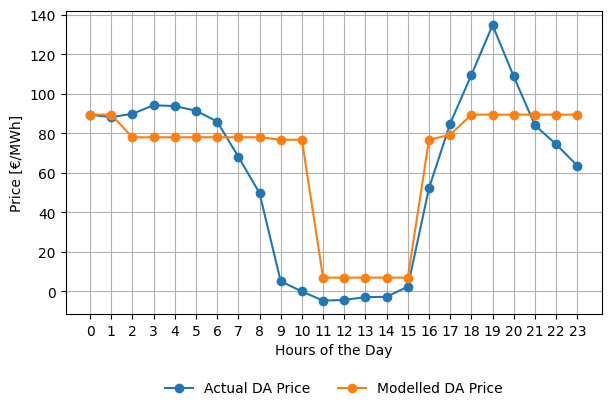

Saved: Pictures/da_price_day201.svg


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- SVG: keep text editable so LaTeX matches document fonts ---
rcParams['svg.fonttype'] = 'none'

# --- ensure output folder exists ---
os.makedirs("Pictures", exist_ok=True)

# --- (re)build the combined dataframe like in your snippet ---
DA_Actuals = DA_Actuals.rename(columns={"Deutschland/Luxemburg [€/MWh]": "Actual_DA_Price"})
Situation2024_0 = Situation2024_0.rename(columns={"Scenario_2_DA": "Modelled_DA_Price"})

combined_df = pd.concat(
    [DA_Actuals["Actual_DA_Price"], Situation2024_0["Modelled_DA_Price"]],
    axis=1
).dropna()

# --- choose which day to plot ---
day_index = 200  # 0-based; change as needed
start = day_index * 24
end   = start + 24

subset_df = combined_df.iloc[start:end]
hours = range(24)

# --- plot (same structure as your SVG workflow) ---
plt.figure(figsize=(6, 4), constrained_layout=True)
plt.plot(subset_df.index, subset_df["Actual_DA_Price"],   label="Actual DA Price",   marker='o', color="#1f77b4")
plt.plot(subset_df.index, subset_df["Modelled_DA_Price"], label="Modelled DA Price", marker='o', color="#ff7f0e")

plt.xlabel("Hours of the Day")
plt.ylabel("Price [€/MWh]")
plt.xticks(ticks=subset_df.index, labels=hours)  # show 0..23
plt.grid(True)

# legend below plot
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=False
)

# --- save SVG and also show locally ---
outfile = f"Pictures/da_price_day{day_index+1}.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Data Prep for further plotting

In [14]:
FinalCapacityResults = cap_df.pivot(index='Plant', columns='Case', values='Capacity').reset_index()


In [15]:
# Step 1: Convert FinalCapacityResults to numeric (if needed)
FinalCapacityResults_numeric = FinalCapacityResults.apply(pd.to_numeric, errors='coerce')

# Step 2: Extract capacity from CapExidf
existing_capacity = CapExidf['Capacity [GW]']  # Adjust if name is different

# Step 3: Add row-wise using index alignment
TotalCapacity = FinalCapacityResults_numeric.add(existing_capacity, axis=0)


### Plotting dispatch for one day

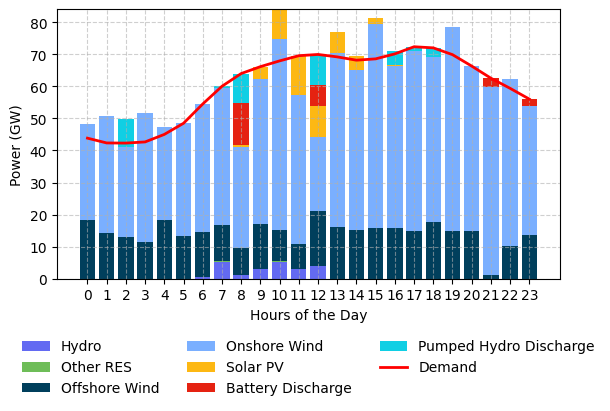

Saved: Pictures/stacked_generation_day2.svg


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- SVG: keep text editable so LaTeX matches document fonts ---
rcParams['svg.fonttype'] = 'none'

# --- ensure output folder ---
os.makedirs("Pictures", exist_ok=True)

# --- select one day ---
start_hour = 0 + 24 * 1
end_hour   = 24 + 24 * 1
one_day = res_DA.DA_EGen_Scenarios['DA_Scenario_1'].query(
    f"Hour >= {start_hour} & Hour < {end_hour}"
).copy()

# x-axis hours (0..23 shown as labels later)
hours = one_day['Hour'].to_numpy()
labels_0_23 = np.arange(24)

# generation & discharge sources (only those present will be plotted)
generation_sources = {
    'Hydro': one_day['Hydro'],
    'Other RES': one_day['Other RES'],
    'Offshore Wind': one_day['Offshore'],
    'Onshore Wind': one_day['Onshore'],
    'Solar PV': one_day['Solar PV'],
    'Nuclear': one_day['Nuclear'],
    'Lignite': one_day['Lignite'],
    'Hard Coal': one_day['Hard Coal'],
    'Biomass': one_day['Biomass'],
    'Gas': one_day['Gas'],
    'Other Conventional': one_day['Other Conventional'],
    'Hydrogen': one_day['Hydrogren'],              # <- column name per your code
    'Battery Discharge': one_day['Battery_Discharge'],
    'Pumped Hydro Discharge': one_day['PumpedHydro_Discharge'],
}

# colors
color_map = {
    'Solar PV': '#FDB813',
    'Offshore Wind': '#003f5c',
    'Onshore Wind': '#7aafff',
    'Hydro': "#636AF2",
    'Gas': '#7F7F7F',
    'Nuclear': "#E52211",
    'Battery Discharge': "#E52211",
    'Pumped Hydro Discharge': "#10CFE4",
    'Other RES': "#6EBD58",
    'Lignite': "#844008",
    'Hard Coal': 'black',
    'Biomass': "#1A540A",
    'Other Conventional': "#DB15BA",
    'Hydrogen': "#0E5DBE",
}

# --- plot ---
plt.figure(figsize=(6, 4), constrained_layout=True)

bottom_stack = np.zeros(len(hours), dtype=float)
handles, labels = [], []

for name, series in generation_sources.items():
    vals = np.asarray(series, dtype=float)
    if np.nansum(vals) > 0:
        bar = plt.bar(hours, vals, bottom=bottom_stack,
                      label=name, color=color_map.get(name, 'gray'))
        handles.append(bar)
        labels.append(name)
        bottom_stack += vals

# demand line (optional)
if 'Demand' in one_day.columns and np.nansum(one_day['Demand'].to_numpy()) > 0:
    ln, = plt.plot(hours, one_day['Demand'], color='red', linewidth=2, label='Demand')
    handles.append(ln)
    labels.append('Demand')

plt.xlabel("Hours of the Day")
plt.ylabel("Power (GW)")
plt.xticks(ticks=hours, labels=labels_0_23)
plt.grid(True, linestyle='--', alpha=0.6)

# legend below plot
plt.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=3,
    frameon=False
)

# --- save SVG & show ---
outfile = "Pictures/stacked_generation_day2.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting carbon intensity

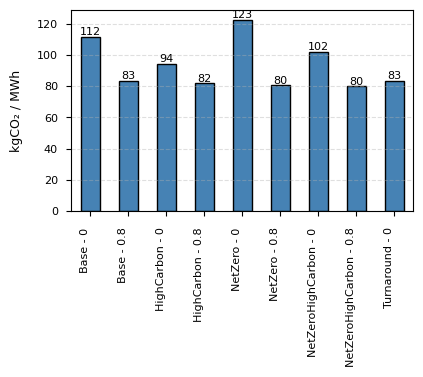

Saved: Pictures/co2_intensity_by_scenario.svg


In [17]:
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- SVG: keep text editable so LaTeX matches document fonts ---
rcParams['svg.fonttype'] = 'none'

# Ensure output folder
os.makedirs("Pictures", exist_ok=True)

# --- mapping ---
scenario_name_map = {
    'ReferenceCase_0': 'Base - 0',
    'ReferenceCase_0.8': 'Base - 0.8',
    'HighFuel_0': 'HighCarbon - 0',
    'HighFuel_0.8': 'HighCarbon - 0.8',
    'NetZero_0': 'NetZero - 0',
    'NetZero_0.8': 'NetZero - 0.8',
    'HighFuel_NetZero_0': 'NetZeroHighCarbon - 0',
    'HighFuel_NetZero_0.8': 'NetZeroHighCarbon - 0.8',
    'PoliticalTurnaround_0': 'Turnaround - 0'
}
display_to_internal = {v: k for k, v in scenario_name_map.items()}

ordered_display_names = [
    'Base - 0', 'Base - 0.8',
    'HighCarbon - 0', 'HighCarbon - 0.8',
    'NetZero - 0', 'NetZero - 0.8',
    'NetZeroHighCarbon - 0', 'NetZeroHighCarbon - 0.8',
    'Turnaround - 0'
]

# --- build series ---
valid_internal_names = [
    display_to_internal[name]
    for name in ordered_display_names
    if display_to_internal[name] in kpi_df.columns
]
co2_series = kpi_df.loc['Average CO2 Intensity', valid_internal_names].copy()
co2_series.index = [scenario_name_map[n] for n in valid_internal_names]

# --- plot (same reference style as RES plot) ---
fig, ax = plt.subplots(figsize=(4, 3))
co2_series.plot(kind='bar', color='steelblue', edgecolor='black', ax=ax)

# value labels
for i, v in enumerate(co2_series):
    ax.text(i, v + 0.002, f'{v:.0f}', ha='center', va='bottom', fontsize=8)

# axes & grid
ax.set_ylabel('kgCO₂ / MWh', fontsize=9, labelpad=10)
ax.set_xlabel('')
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# --- tick labels like the working reference ---
for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_horizontalalignment('right')   # same as reference
    lbl.set_verticalalignment('bottom')    # consistent baseline
    lbl.set_rotation_mode('anchor')
ax.tick_params(axis='x', labelsize=8, pad=8)
ax.tick_params(axis='y', labelsize=8, pad=6)

# margins (use manual spacing instead of tight_layout)
plt.subplots_adjust(top=0.95, bottom=0.28, right=0.98)

# --- save SVG ---
outfile = "Pictures/co2_intensity_by_scenario.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting objetive value

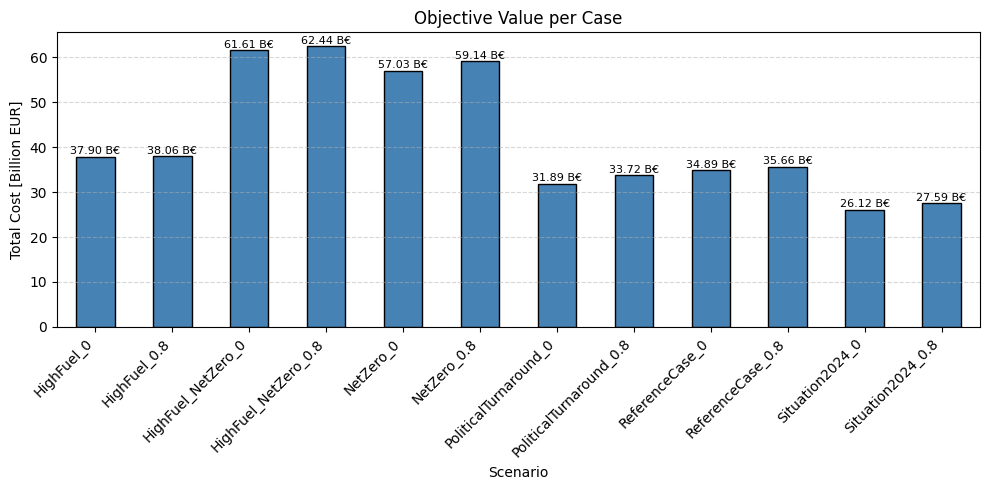

In [18]:
import matplotlib.pyplot as plt

# Extract the objective value row
obj_series = kpi_df.loc['Objective Value']

# Convert to billions if needed for better readability
obj_series_billion = obj_series / 1e9

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
obj_series_billion.plot(kind='bar', color='steelblue', edgecolor='black', ax=ax)

# Add data labels
for i, (label, value) in enumerate(obj_series_billion.items()):
    ax.text(i, value + 0.05, f'{value:.2f} B€', ha='center', va='bottom', fontsize=8)

# Style
plt.title('Objective Value per Case')
plt.ylabel('Total Cost [Billion EUR]')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


### Plotting average RES share

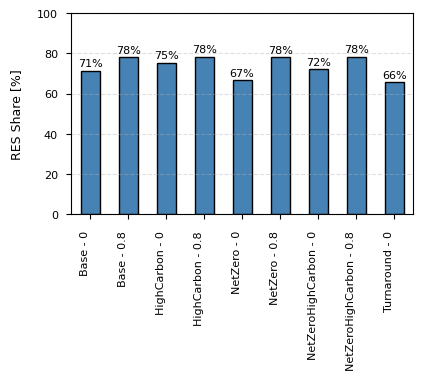

Saved: Pictures/res_share_by_scenario_small.svg


In [19]:
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- SVG: keep text editable so LaTeX matches document fonts ---
rcParams['svg.fonttype'] = 'none'

# Ensure output folder
os.makedirs("Pictures", exist_ok=True)

# --- mapping ---
scenario_name_map = {
    'ReferenceCase_0': 'Base - 0',
    'ReferenceCase_0.8': 'Base - 0.8',
    'HighFuel_0': 'HighCarbon - 0',
    'HighFuel_0.8': 'HighCarbon - 0.8',
    'NetZero_0': 'NetZero - 0',
    'NetZero_0.8': 'NetZero - 0.8',
    'HighFuel_NetZero_0': 'NetZeroHighCarbon - 0',
    'HighFuel_NetZero_0.8': 'NetZeroHighCarbon - 0.8',
    'PoliticalTurnaround_0': 'Turnaround - 0'
}
display_to_internal = {v: k for k, v in scenario_name_map.items()}

ordered_display_names = [
    'Base - 0', 'Base - 0.8',
    'HighCarbon - 0', 'HighCarbon - 0.8',
    'NetZero - 0', 'NetZero - 0.8',
    'NetZeroHighCarbon - 0', 'NetZeroHighCarbon - 0.8',
    'Turnaround - 0'
]

# --- build series ---
valid_internal_names = [
    display_to_internal[name]
    for name in ordered_display_names
    if display_to_internal[name] in kpi_df.columns
]
res_share_series = kpi_df.loc['Average RES Share', valid_internal_names].copy()
res_share_series.index = [scenario_name_map[n] for n in valid_internal_names]
res_share_series *= 100  # percent

# --- plot (reference style) ---
fig, ax = plt.subplots(figsize=(4, 3))
res_share_series.plot(kind='bar', color='steelblue', edgecolor='black', ax=ax)

# value labels
for i, v in enumerate(res_share_series):
    ax.text(i, v + 1, f'{v:.0f}%', ha='center', va='bottom', fontsize=8)

# axes & grid
ax.set_ylabel('RES Share [%]', fontsize=9, labelpad=10)
ax.set_xlabel('')
ax.set_ylim(0, min(max(res_share_series.max() + 10, 100), 110))
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# --- tick labels like the working reference ---
for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_horizontalalignment('right')   # same as reference
    lbl.set_verticalalignment('bottom')    # consistent baseline
    lbl.set_rotation_mode('anchor')
ax.tick_params(axis='x', labelsize=8, pad=8)
ax.tick_params(axis='y', labelsize=8, pad=6)

# margins (use manual spacing instead of tight_layout)
plt.subplots_adjust(top=0.95, bottom=0.28, right=0.98)

# --- save SVG ---
outfile = "Pictures/res_share_by_scenario_small.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting Capture Prices

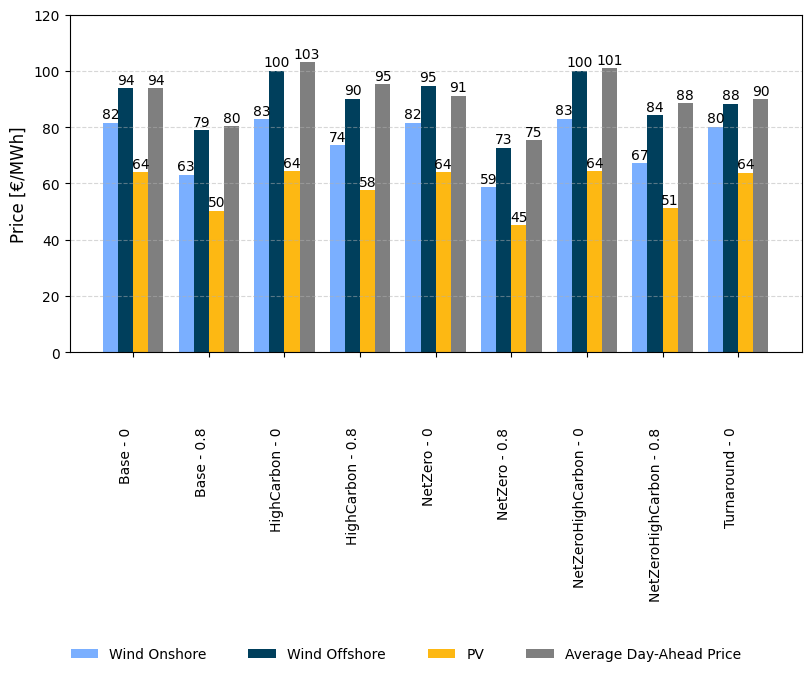

Saved: Pictures/capture_price_comparison_medium.svg


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Keep SVG text editable for LaTeX
rcParams['svg.fonttype'] = 'none'
os.makedirs("Pictures", exist_ok=True)

# --- mapping ---
scenario_name_map = {
    'ReferenceCase_0': 'Base - 0',
    'ReferenceCase_0.8': 'Base - 0.8',
    'HighFuel_0': 'HighCarbon - 0',
    'HighFuel_0.8': 'HighCarbon - 0.8',
    'NetZero_0': 'NetZero - 0',
    'NetZero_0.8': 'NetZero - 0.8',
    'HighFuel_NetZero_0': 'NetZeroHighCarbon - 0',
    'HighFuel_NetZero_0.8': 'NetZeroHighCarbon - 0.8',
    'PoliticalTurnaround_0': 'Turnaround - 0'
}

ordered_display_names = [
    'Base - 0', 'Base - 0.8',
    'HighCarbon - 0', 'HighCarbon - 0.8',
    'NetZero - 0', 'NetZero - 0.8',
    'NetZeroHighCarbon - 0', 'NetZeroHighCarbon - 0.8',
    'Turnaround - 0'
]

# Reverse lookup
display_to_internal = {v: k for k, v in scenario_name_map.items()}
valid_internal = [display_to_internal[name] for name in ordered_display_names if display_to_internal[name] in capture_price_df.columns]
valid_display = [scenario_name_map[name] for name in valid_internal]

# Filter and transpose
selected_techs = ['Wind Onshore', 'Wind Offshore', 'PV', 'Average_DA_Price']
plot_df = capture_price_df.loc[selected_techs, valid_internal].T
plot_df.index = valid_display

# --- plotting ---
x = np.arange(len(plot_df))
techs = plot_df.columns
width = 0.2
tech_colors = {
    'Wind Onshore': '#7aafff',
    'Wind Offshore': '#003f5c',
    'PV': '#FDB813',
    'Average_DA_Price': '#7F7F7F'
}

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

handles = []
labels = []
for i, tech in enumerate(techs):
    bars = ax.bar(x + i * width, plot_df[tech].values, width=width,
                  label=tech, color=tech_colors.get(tech, 'gray'))
    handles.append(bars[0])
    labels.append('Average Day-Ahead Price' if tech == 'Average_DA_Price' else tech)
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax.text(b.get_x() + b.get_width()/2, h + 0.5, f'{h:.0f}',
                    ha='center', va='bottom', fontsize=10)

# Y-axis limit
ax.set_ylim(0, 120)

# Axis formatting
ax.set_ylabel('Price [€/MWh]', fontsize=12)
ax.set_xticks(x + width * (len(techs) - 1) / 2)
ax.set_xticklabels(plot_df.index, rotation=90, ha='right', fontsize=10)
ax.tick_params(axis='x', pad=50)  # move labels slightly down
plt.yticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
fig.legend(handles=handles, labels=labels, loc='upper center',
           bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=10, columnspacing=3.0,frameon=False)

# Save SVG
outfile = "Pictures/capture_price_comparison_medium.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting Day ahead and intraday prices for a certain time period

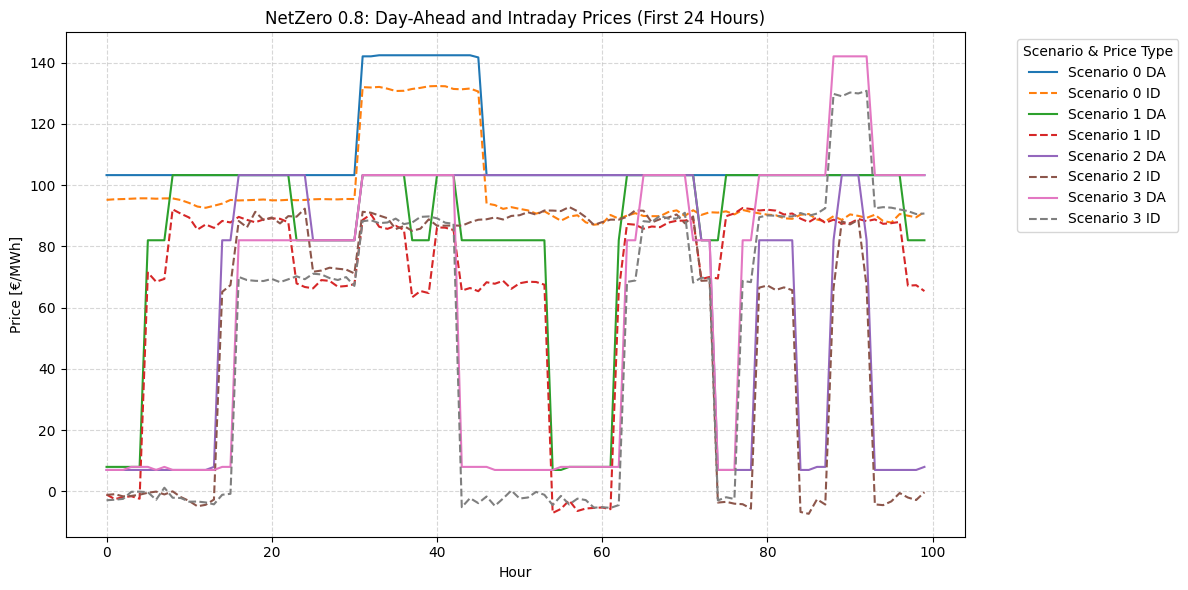

In [21]:
df_prices = DA_ID_price_frames['ReferenceCase_0']  # <-- exact string
subset = df_prices.iloc[0:100]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for col in subset.columns:
    linestyle = '-' if 'DA' in col else '--'
    plt.plot(subset.index, subset[col], linestyle=linestyle, label=col.replace('_', ' '))

plt.title('NetZero 0.8: Day-Ahead and Intraday Prices (First 24 Hours)')
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Scenario & Price Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Plotting Duck curve

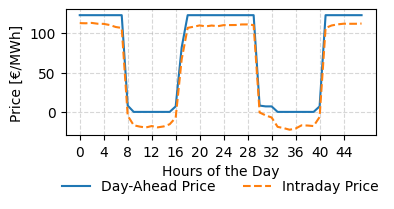

Saved: Pictures/da_vs_id_48h_s2_0RES.svg


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Keep SVG text editable so LaTeX matches your document fonts
rcParams['svg.fonttype'] = 'none'

# Output folder
os.makedirs("Pictures", exist_ok=True)

# --- your data slice ---
case_id = 'HighFuel_NetZero_0'
df = DA_ID_price_frames[case_id]

start_index = 24 * 144
end_index   = 24 * (145 + 1)
da_prices = df['Scenario_2_DA'].iloc[start_index:end_index]
id_prices = df['Scenario_2_ID'].iloc[start_index:end_index]

# x-axis (0..47) and labels every 4 hours
x = np.arange(48)

# --- plot ---
plt.figure(figsize=(4, 2))  # compact, adjust if you want
plt.plot(x, da_prices.values, label='Day-Ahead Price', linestyle='-', linewidth=1.5)
plt.plot(x, id_prices.values, label='Intraday Price', linestyle='--', linewidth=1.5)

plt.xlabel('Hours of the Day')
plt.ylabel('Price [€/MWh]')
plt.xticks(ticks=np.arange(0, 48, 4))
plt.grid(True, linestyle='--', alpha=0.5)

# Legend below the chart
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False)

# Reserve space for legend and save SVG
plt.subplots_adjust(bottom=0.25)
outfile = "Pictures/da_vs_id_48h_s2_0RES.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Plotting BESS NPV

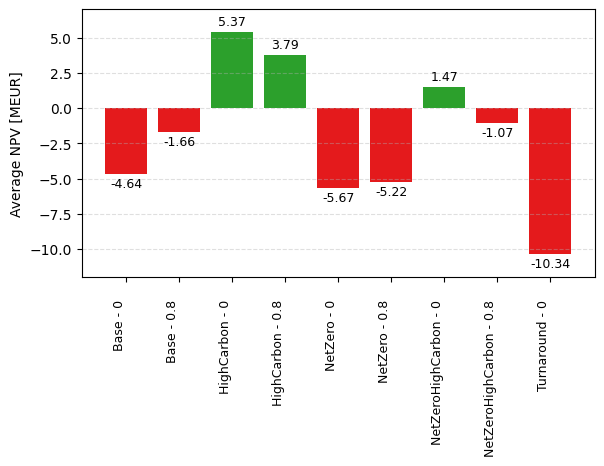

Saved: Pictures/avg_npv_by_scenario.svg


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Keep SVG text editable
rcParams['svg.fonttype'] = 'none'

# Ensure output folder exists
os.makedirs("Pictures", exist_ok=True)

# --- Hardcoded data ---
labels = [
    'Base - 0', 'Base - 0.8',
    'HighCarbon - 0', 'HighCarbon - 0.8',
    'NetZero - 0', 'NetZero - 0.8',
    'NetZeroHighCarbon - 0', 'NetZeroHighCarbon - 0.8',
    'Turnaround - 0'
]
values = np.array([-4.64, -1.66, 5.37, 3.79, -5.67, -5.22, 1.47, -1.07, -10.34])

# Colors: green for positive, red for negative/zero
colors = ['#2ca02c' if v > 0 else '#e41a1c' for v in values]

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(len(labels))
bars = ax.bar(x, values, color=colors)

# Y-axis label and limits
ax.set_ylabel('Average NPV [MEUR]')
ax.set_ylim(-12, 7)

# X-axis labels: consistent baseline alignment
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=9)
for lbl in ax.get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_horizontalalignment('right')
    lbl.set_verticalalignment('bottom')
    lbl.set_rotation_mode('anchor')
ax.tick_params(axis='x', pad=12)  # space away from axis

# Grid lines
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Data labels
for i, (b, v) in enumerate(zip(bars, values)):
    if v >= 0:
        y = v + 0.25
        va = 'bottom'
    else:
        y = v - 0.25
        va = 'top'
    ax.text(b.get_x() + b.get_width()/2, y, f'{v:.2f}',
            ha='center', va=va, fontsize=9)

# Adjust layout so caption in LaTeX sits closer
plt.subplots_adjust(top=0.95, bottom=0.28, right=0.98)

# Save SVG
outfile = "Pictures/avg_npv_by_scenario.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Preparing Data for price distribution plot

In [24]:
import pandas as pd

# Create an empty dictionary to collect stacked DA prices
stacked_da_prices = {}

# Loop over each scenario's DataFrame
for scenario_name, df in DA_ID_price_frames.items():
    # Select and stack all 4 DA price columns: Scenario_0_DA to Scenario_3_DA
    da_columns = [f"Scenario_{i}_DA" for i in range(4) if f"Scenario_{i}_DA" in df.columns]
    stacked_series = pd.concat([df[col] for col in da_columns], ignore_index=True)
    
    # Add to dictionary
    stacked_da_prices[scenario_name] = stacked_series

# Convert to DataFrame
stacked_df = pd.DataFrame(stacked_da_prices)

# Display shape or head
stacked_df.head()


,ReferenceCase_0,ReferenceCase_0.8,HighFuel_0,HighFuel_0.8,NetZero_0,NetZero_0.8,HighFuel_NetZero_0,HighFuel_NetZero_0.8,Situation2024_0,Situation2024_0.8,PoliticalTurnaround_0,PoliticalTurnaround_0.8
0,103.25,103.25,122.94,122.94,103.25,103.25,122.94,122.94,89.488,78.033436,103.25,103.25
1,103.25,103.25,122.94,122.94,103.25,103.25,122.94,122.94,89.488,78.033436,103.25,103.25
2,103.25,103.25,122.94,122.94,103.25,103.25,122.94,122.94,89.488,78.033436,103.25,103.25
3,103.25,103.25,122.94,122.94,103.25,103.25,122.94,122.94,89.488,78.033436,103.25,103.25
4,103.25,103.25,122.94,122.94,103.25,103.25,122.94,122.94,89.488,78.033436,103.25,103.25


### Plotting Price Distribution

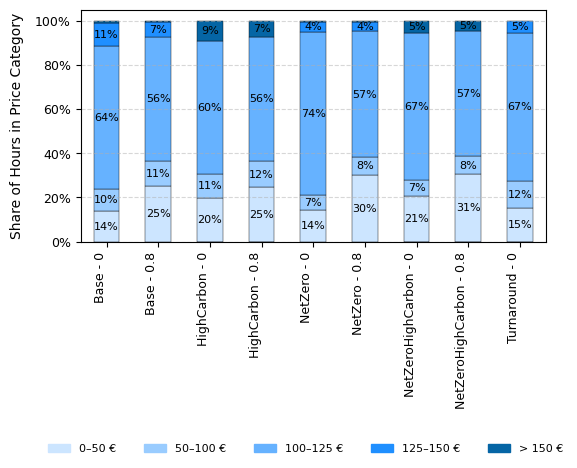

Saved: Pictures/da_price_distribution_by_scenario.svg


In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter

# --- SVG: keep text editable so LaTeX matches document fonts ---
rcParams['svg.fonttype'] = 'none'

# Ensure output folder
os.makedirs("Pictures", exist_ok=True)

# -----------------------------
# SCENARIO MAPPING AND ORDERING
# -----------------------------
scenario_name_map = {
    'ReferenceCase_0': 'Base - 0',
    'ReferenceCase_0.8': 'Base - 0.8',
    'HighFuel_0': 'HighCarbon - 0',
    'HighFuel_0.8': 'HighCarbon - 0.8',
    'NetZero_0': 'NetZero - 0',
    'NetZero_0.8': 'NetZero - 0.8',
    'HighFuel_NetZero_0': 'NetZeroHighCarbon - 0',
    'HighFuel_NetZero_0.8': 'NetZeroHighCarbon - 0.8',
    'PoliticalTurnaround_0': 'Turnaround - 0'
}
ordered_display_names = [
    'Base - 0', 'Base - 0.8',
    'HighCarbon - 0', 'HighCarbon - 0.8',
    'NetZero - 0', 'NetZero - 0.8',
    'NetZeroHighCarbon - 0', 'NetZeroHighCarbon - 0.8',
    'Turnaround - 0'
]
display_to_internal = {v: k for k, v in scenario_name_map.items()}

# ------------------------
# CUSTOMIZE PRICE INTERVALS
# ------------------------
bins = [0, 50, 100, 125, 150, float('inf')]
labels = ['0–50 €', '50–100 €', '100–125 €', '125–150 €', '> 150 €']

# Colors (length must match number of bins/labels)
blue_shades = ['#cce5ff', '#99ccff', '#66b2ff', "#1f8fff", "#0565a5"]
colors = blue_shades[:len(labels)]

# ------------------------
# CALCULATE PERCENTAGE DISTRIBUTIONS
# ------------------------
category_percentages = pd.DataFrame(index=labels)

for display_name in ordered_display_names:
    internal_name = display_to_internal.get(display_name)
    if internal_name in stacked_df.columns:
        series = stacked_df[internal_name]
        binned = pd.cut(series, bins=bins, labels=labels, right=True, include_lowest=True)
        counts = binned.value_counts(sort=False)
        percentages = counts / counts.sum() * 100
        category_percentages[display_name] = percentages

category_percentages = category_percentages.T  # rows: scenarios, cols: bins

# ------------------------
# PLOT (SVG)
# ------------------------
fig, ax = plt.subplots(figsize=(6, 4))  # compact; adjust if needed
category_percentages.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=0.3,
    legend=False  # remove default legend
)

# % labels in each stacked segment
for i, (_, row) in enumerate(category_percentages.iterrows()):
    cum = 0.0
    for val in row.values:
        if val > 1:  # skip tiny labels
            ax.text(i, cum + val/2, f"{val:.0f}%", ha='center', va='center', fontsize=8)
        cum += val

# Styling
ax.set_ylabel("Share of Hours in Price Category", fontsize=10, labelpad=8)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.yticks(fontsize=9)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Custom legend below
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=len(labels),
    fontsize=8,
    frameon=False,
    columnspacing=2.5,
    handletextpad=0.8,
    labelspacing=1.0
)

# Space for legend and save SVG
plt.subplots_adjust(bottom=0.30)
outfile = "Pictures/da_price_distribution_by_scenario.svg"
plt.savefig(outfile, format="svg", bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved: {outfile}")


### Preparing Data for testing with unseen scenarios

In [26]:
# Separate out the storage rows
FinalStorageUnseen = FinalCapacityResults[
    FinalCapacityResults["Plant"].isin(["Battery", "Pumped Hydro"])
]

# Keep only the non-storage rows
filtered_df = FinalCapacityResults[
    ~FinalCapacityResults["Plant"].isin(["Battery", "Pumped Hydro"])
]

# Define the desired order
desired_order = [
    "Offshore", "Onshore", "Biomass", "Lignite", "Hard Coal", "Gas", "Hydrogren", "Nuclear",
    "Solar PV", "Hydro", "Other RES", "Other Conventional"
]

# Filter to include only desired rows and reorder
filtered_df = filtered_df[filtered_df["Plant"].isin(desired_order)]

filtered_df["Plant"] = pd.Categorical(
    filtered_df["Plant"], categories=desired_order, ordered=True
)

FinalCapacityResultsUnseen = filtered_df.sort_values("Plant").reset_index(drop=True)


### Creating scenarios for unseen weather years

In [27]:
CapacityFactorsUnseen = pd.read_excel('Data/UnseenScenarios/CapacityFactors_2017_2020.xlsx')
ProdFacOffWindUnseen = np.array(CapacityFactorsUnseen['Offshore Capacity Factor'])
ProdFacOnWindUnseen = np.array(CapacityFactorsUnseen['Onshore Capacity Factor'])
ProdFacSolarUnseen = np.array(CapacityFactorsUnseen['Solar Capacity Factor'])


#Sampling Scenarios for unseen data


# Constants
years = [2017,2018,2019,2020]  # List of years for which scenarios are generated
hours_per_year = len(Demand)
scenarios_per_year = 4 # Change this to generate more per year
num_years = len(years)
total_scenarios = num_years * scenarios_per_year
N_Scen = scenarios_per_year * len(years)

# Initialize final scenario arrays
Offwind_scenarios_Unseen = np.zeros((hours_per_year, total_scenarios))
Onwind_scenarios_Unseen = np.zeros((hours_per_year, total_scenarios))
Solar_scenarios_Unseen = np.zeros((hours_per_year, total_scenarios))

for i, year in enumerate(years):
    start = i * hours_per_year

    # Step 1: Build distribution dictionary from that year's data
    OffWindDistributionsUnseen = {}
    OnWindDistributionsUnseen = {}
    solar_distributionsUnseen = {}

    for hour in range(hours_per_year):
        idx = start + hour

        OffWindMeanUnseen = ProdFacOffWindUnseen[idx]
        Offwind_std_dev_Unseen = max(0.17 * OffWindMeanUnseen, 0.0)
        OffWindDistributionsUnseen[hour] = (OffWindMeanUnseen, Offwind_std_dev_Unseen)

        OnWindMeanUnseen = ProdFacOnWindUnseen[idx]
        Onwind_std_dev_Unseen = max(0.17 * OnWindMeanUnseen, 0.0)
        OnWindDistributionsUnseen[hour] = (OnWindMeanUnseen, Onwind_std_dev_Unseen)

        solar_mean_Unseen = ProdFacSolarUnseen[idx]
        solar_std_dev_Unseen = max(0.1 * solar_mean_Unseen, 0.0)
        solar_distributionsUnseen[hour] = (solar_mean_Unseen, solar_std_dev_Unseen)

    # Step 2: Generate multiple scenarios from this year
    for s in range(scenarios_per_year):
        col_index = i * scenarios_per_year + s

        for hour in range(hours_per_year):
            # Offshore
            mean, std = OffWindDistributionsUnseen[hour]
            sample = np.random.normal(mean, std)
            Offwind_scenarios_Unseen[hour, col_index] = np.clip(sample, 0, 1) 

            # Onshore
            mean, std = OnWindDistributionsUnseen[hour]
            sample = np.random.normal(mean, std)
            Onwind_scenarios_Unseen[hour, col_index] = np.clip(sample, 0, 1) 

            # Solar
            mean, std = solar_distributionsUnseen[hour]
            sample = np.random.normal(mean, std)
            Solar_scenarios_Unseen[hour, col_index] = np.clip(sample, 0, 1) 



### Calculating average capacity factor of unseen weather years

In [28]:
avg_offshore_cf = Offwind_scenarios_Unseen.mean()
avg_onshore_cf = Onwind_scenarios_Unseen.mean()
avg_solar_cf = Solar_scenarios_Unseen.mean()

print("Average Capacity Factors:")
print(f"Offshore Wind: {avg_offshore_cf:.3f}")
print(f"Onshore Wind: {avg_onshore_cf:.3f}")
print(f"Solar: {avg_solar_cf:.3f}")


Average Capacity Factors:
Offshore Wind: 0.435
Onshore Wind: 0.210
Solar: 0.107


### Executing the dispatch model with fixed capacity

In [30]:
SetofCases = ['ReferenceCase','HighFuel', 'NetZero','HighFuel_NetZero','Situation2024','PoliticalTurnaround']#,'HighFuel', 'NetZero','HighFuel_NetZero']#,#'SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel'] #SetofCases = ['SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel']
SetofDeltas = [0,0.8]


average_total_gen_dict = {}
res_share_dict = {}

for RunScenario in SetofCases:
    for delta in SetofDeltas:
        print(f'Running scenario: {RunScenario} with delta: {delta}')
        case_id = f'{RunScenario}_{delta}'
        # Extract as ndarray for DayAheadProblem
        ResultsCapacity = FinalCapacityResultsUnseen[case_id].to_numpy()
        ResultsStorage = FinalStorageUnseen[case_id].to_numpy()
        
        # Load scenario data
        Demand, OpCost, CapOut, CO2Intensity, FixedOpex, StorExi, CapExi, CapLim = get_scenario_data(RunScenario)
        BigM = delta * sum(Demand)
        CapExidf = pd.read_excel('Data/UnseenScenarios/ExistingCapacity.xlsx')
        #opex_df = pd.read_excel('Data/UnseenScenarios/OPEX.xlsx')
        CapExi = np.array(CapExidf['Capacity [GW]'])
        #OpCost = np.array(opex_df['Total OPEX [€/GWh]'])    

        ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM, BatteryCapacity, BatterPower)
        DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim, CapExi, CapOut,
                            Demand, EtaCh, EtaDis, StorExi, Offwind_scenarios_Unseen,
                            Onwind_scenarios_Unseen, Solar_scenarios_Unseen, StorLim, CO2Intensity,StorCost_DF,FixedOpex,StorOpex,BatteryEfficiency)

        

        # Run day-ahead model
        DA_problem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage, IDForecaster)
        res_DA = DA_problem.res
        DayAheadPrices = res_DA.DA_Prices
        IntraDayPrices = res_DA.IntraDay_PricesArray
        DayAheadPricesTransformed = DayAheadPrices.to_numpy()
        res_share_dict[case_id] = res_DA.RESShare.flatten()

        # ---------------------
        # 1. Save DA/ID prices
        

        columns = []
        price_columns = []

        for s in range(ParametersObj.N_Scen):
            DA_col = f"Scenario_{s}_DA"
            ID_col = f"Scenario_{s}_ID"
            columns.extend([DA_col, ID_col])

            DA_prices = res_DA.DA_Prices.iloc[:, s].values
            ID_prices = res_DA.IntraDay_PricesArray[:, s]

            price_columns.append(DA_prices)
            price_columns.append(ID_prices)

        # Stack all DA/ID columns horizontally
        data = np.column_stack(price_columns)

        # Build DataFrame with Hour index
        df_prices = pd.DataFrame(data, columns=columns)
        df_prices['Hour'] = range(ParametersObj.N_Hours)
        DA_ID_price_frames[case_id] = df_prices.set_index('Hour')

        # ---------------------
        # 2. Save capture prices
        tech_means = res_DA.CapturePrices.astype(float).mean(axis=1)
        capture_price_dict[case_id] = tech_means

        # ---------------------
        # 3. Save std deviations
        std_da = res_DA.DA_Prices.std(axis=1).mean()
        std_id = pd.DataFrame(res_DA.IntraDay_PricesArray).std(axis=1).mean()
        stddev_dict['StdDev_DA_Prices'][case_id] = std_da
        stddev_dict['StdDev_ID_Prices'][case_id] = std_id

        # Save generation results
        average_total_gen_dict[f"{RunScenario}_{delta}"] = res_DA.AverageTotalGeneration



       

# ---------------------
# FINAL DATAFRAMES



# Capture Prices
capture_price_df = pd.DataFrame(capture_price_dict)
capture_price_df = capture_price_df[sorted(capture_price_df.columns)]

res_share_df = pd.DataFrame.from_dict(res_share_dict, orient='index')
res_share_df.columns = [f"Scenario_{i}" for i in range(res_share_df.shape[1])]



     



Running scenario: ReferenceCase with delta: 0
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3503936 rows, 2522880 columns and 7568416 nonzeros
Model fingerprint: 0x85b512b2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+03, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 1e+03]
Presolve removed 2186621 rows and 837054 columns (presolve time = 5s) ...
Presolve removed 2466909 rows and 837054 columns
Presolve time: 6.26s
Presolved: 1037027 rows, 1966114 columns, 5160876 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 2.62s

Barrier statistics:
 AA' NZ     : 5.829e+06
 Factor NZ  : 1.414e+07 (roughly 1.3 GB of memory)
 Factor Ops : 2.046e+08 (les

In [31]:
# Select only columns starting with 'Scenario_'
scenario_cols = [col for col in res_share_df.columns if col.startswith("Scenario_")]

# Compute average over scenario columns only
res_share_df["Average_RES_Share"] = res_share_df[scenario_cols].mean(axis=1)

# Count how many values are below 0.8
res_share_df["Count_below_0.8"] = (res_share_df[scenario_cols] < 0.8).sum(axis=1)

# Divide by N_Scen to get fraction
res_share_df["Fraction_below_0.8"] = res_share_df["Count_below_0.8"] / N_Scen
